In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 주택 가격 예측: 회귀 문제


이 예제는 개별적인 레이블 대신에 연속적인 값을 예측하는 회귀(regression) 문제이다. 

로지스틱 회귀는 회귀 알고리즘이 아니라 분류 알고리즘이다.

> 보스턴 주택 가격 데이터셋 : 
1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측하기.

>*  데이터 포인트가 506개로 비교적 개수가 적다
>*  train : 404개  test : 102개
>* 입력 데이터에 있는 각 특성(예를 들어 범죄율)은 스케일이 서로 다르다. 어떤 값은 0과 1 사이의 비율을 나타내고 어떤 것은 1과 12 사이의 값을 가지거나 1과 100 사이의 값을 가진다.


In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

13개의 특성이 있다.

>1. Per capita crime rate.
>2. Proportion of residential land zoned for lots over 25,000 square feet.
>3. Proportion of non-retail business acres per town.
>4.Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
>5. Nitric oxides concentration (parts per 10 million).
>6. Average number of rooms per dwelling.
>7. Proportion of owner-occupied units built prior to 1940.
>8. Weighted distances to five Boston employment centres.
>9. Index of accessibility to radial highways.
>10. Full-value property-tax rate per $10,000.
>11. Pupil-teacher ratio by town.
>12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
>13. % lower status of the population.

---
target은 주택의 중간 가격으로 천달러 단위이다.

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

일반적으로 10,000달러에서 50,000달러 사이의 가격을 갖는다. 
아직 인플레이션의 영향을 받지 않은 1970년대 가격이다.


# 데이터 준비
상이한 스케일을 가진 값을 신경망에 주입하면 문제가 생긴다. 네트워크가 이런 다양한 데이터에 자동으로 맞추려고 할 수 있지만 이는 확실히 학습을 더 어렵게 만든다. 이런 데이터를 다룰 때 대표적인 방법은 특성별로 정규화를 하는 것이다. 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나눈다. 특성의 중앙이 0 근처에 맞춰지고 표준 편차가 1이 된다. 넘파이를 사용하면 간단하게 할 수 있다.

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

테스트 데이터를 정규화할 때 사용한 값이 훈련 데이터에서 계산한 값이다. 머신 러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안 된다. 


# 모델 구성
샘플의 개수가 적기 때문에 64개의 유닛을 가진 두 개의 은닉층으로 작은 네트워크를 구성하여 사용하자. 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다.

In [0]:
from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없다(선형 층이라 한다). 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성이다. 활성화 함수를 적용하면 출력 값의 범위를 제한하게 된다. 예를 들어 마지막 층에 sigmoid 활성화 함수를 적용하면 네트워크가 0과 1 사이의 값을 예측하도록 학습하게 된다. 여기서는 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습된다.

이 모델은 mse 손실 함수를 사용하여 컴파일한다. 이 함수는 평균 제곱 오차(mean squared error)의 약자로 예측과 타깃 사이 거리의 제곱이다. 회귀 문제에서 널리 사용되는 손실 함수다.

훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차를 측정한다. 이는 예측과 타깃 사이 거리의 절댓값이다. 예를 들어 이 예제에서 MAE가 0.5이면 예측이 평균적으로 $500 정도 차이가 난다는 뜻이다.

# K-겹 검증을 사용한 훈련 검증
데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아진다(약 100개의 샘플). 결국 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택됐는지에 따라 검증 점수가 크게 달라 진다. 검증 세트의 분할에 대한 검증 점수의 분산이 높다. 이렇게 되면 신뢰있는 모델 평가를 못한다.

이런 상황에서 가장 좋은 방법은 K-겹 교차 검증을 사용하는 것이다. 데이터를 K개의 분할(즉, 폴드)로 나누고(일반적으로 K = 4 또는 5), K개의 모델을 각각 만들어 K - 1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법. 모델의 검증 점수는 K 개의 검증 점수의 평균이 된다.

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [9]:
all_scores

[2.149232221121835, 2.161251714914152, 2.7750930691709614, 2.3329986918090593]

In [10]:
np.mean(all_scores)

2.354643924254002

검증 세트가 다르므로 확실히 검증 점수가 2.0에서 2.8까지 변화가 크다. 평균값(2.4)이 각각의 점수보다 훨씬 신뢰할 만한 점수다. 이것이 K-겹 교차 검증의 핵심이다. 이 예에서는 평균적으로 3,000달러 정도 차이가 난다. 주택 가격의 범위가 10,000달러에서 50,000달러 사이인 것을 감안하면 비교적 큰 값이다.

신경망을 조금 더 오래 500 에포크 동안 훈련하자. 각 에포크마다 모델이 얼마나 개선되는지 기록하기 위해 훈련 루프를 조금 수정해서 에포크의 검증 점수를 로그에 저장하자.

In [0]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [12]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


그다음 모든 폴드에 대해 에포크의 MAE 점수의 평균을 계산한다.

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

그래프로 그려보자.

In [0]:
import matplotlib.pyplot as plt

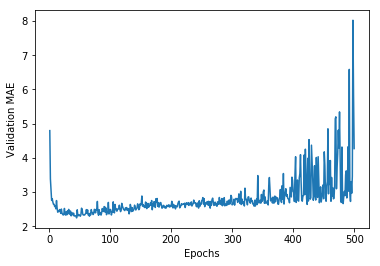

In [15]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프는 범위가 크고 변동이 심하기 때문에 보기가 좀 어렵다.

다른방법을 쓰자.
곡선의 다른 부분과 스케일이 많이 다른 첫 10개 데이터 포인트를 제외시키자.
부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체한다.

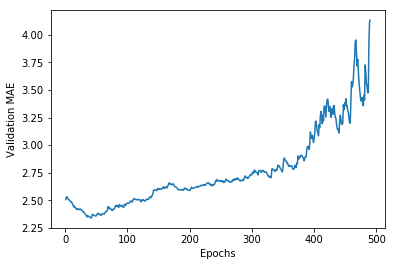

In [16]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프를 보면 검증 MAE가 80번째 에포크 이후에 줄어드는 것이 멈췄다. 이 지점 이후로는 과대적합이 시작된다.

모델의 다른 매개변수에 대한 튜닝이 끝나면(에포크 수뿐만 아니라 은닉층의 크기도 조절할 수 있습니다) 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련한다. 그다음 테스트 데이터로 성능을 확인한자.

In [17]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 845us/step


In [18]:
test_mae_score

2.677526184156829

아직 2,675달러 정도 차이가 난다.

# 정리

>* 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용한다. 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수다.
>* 비슷하게 회귀에서 사용되는 평가 지표는 분류와 다르다. 당연히 정확도 개념은 회귀에 적용되지 않는다. 일반적인 회귀 지표는 평균 절대 오차(MAE)다.
>* 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 한다.
>* 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 신뢰있게 평가 방법이다.
>* 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층의 수를 줄인 모델이 좋다(일반적으로 하나 또는 두 개).
